# H5 X-Ray

Exploring ways to visualize the structure of any HDF5 file. A work in progress!

A weekend project inspired by the h5cloud project at the 2023 ICESat-2 Hackweek.

__Jonathan Markel__  
3D Geospatial Laboratory  
The University of Texas at Austin  
09/09/2023

#### [Twitter](https://twitter.com/jonm3d) | [GitHub](https://github.com/jonm3d) | [Website](http://j3d.space) | [GoogleScholar](https://scholar.google.com/citations?user=KwxwFgYAAAAJ&hl=en) | [LinkedIn](https://www.linkedin.com/in/j-markel/) 

## Notes / Pending Work / Caveats
- Somewhat surprised that the ancillary data is so large for these ICESat-2 files - this may be a bug.
- Plotting ordered by top-level group name alphabetical... Ideally would like to order by byte offset relative to the start of the HDF5 file, but h5py byte offsets are returning NaN for most datasets, and I'm not sure why.
- Some datasets are different dimensions/chunked - how to represent these in the visualization?
- Ideally, the size of the nodes in the tree plot will represent the amount of data in the dataset/subgroups.
- Total reported file size is larger than the file system reported value - this is either a bug or may be due to HDF5 compression.

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import math
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import textwrap
from PIL import Image, ImageDraw, ImageFont # for watermarking plotly static image


# graph plotting tools missing from CryoCloud image
try:
    import igraph as ig
    import kaleido
except:
    !pip install python-igraph
    !pip install -U kaleido # for saving graph
    import igraph as ig

In [94]:
input_file_name = 'atl03_3'
input_file_base = f'data/{input_file_name}'
input_file = f'{input_file_base}.h5'

# Hierarchical Structure Visualization
The HDF5 hierarchichal data format may have groups within groups. Let's see if we can visualize this structure using a commmon tree diagram which shows the nesting/relationships of groups/datasets. Note that organizing the tree layout according to Reingold-Tilford may take several seconds.

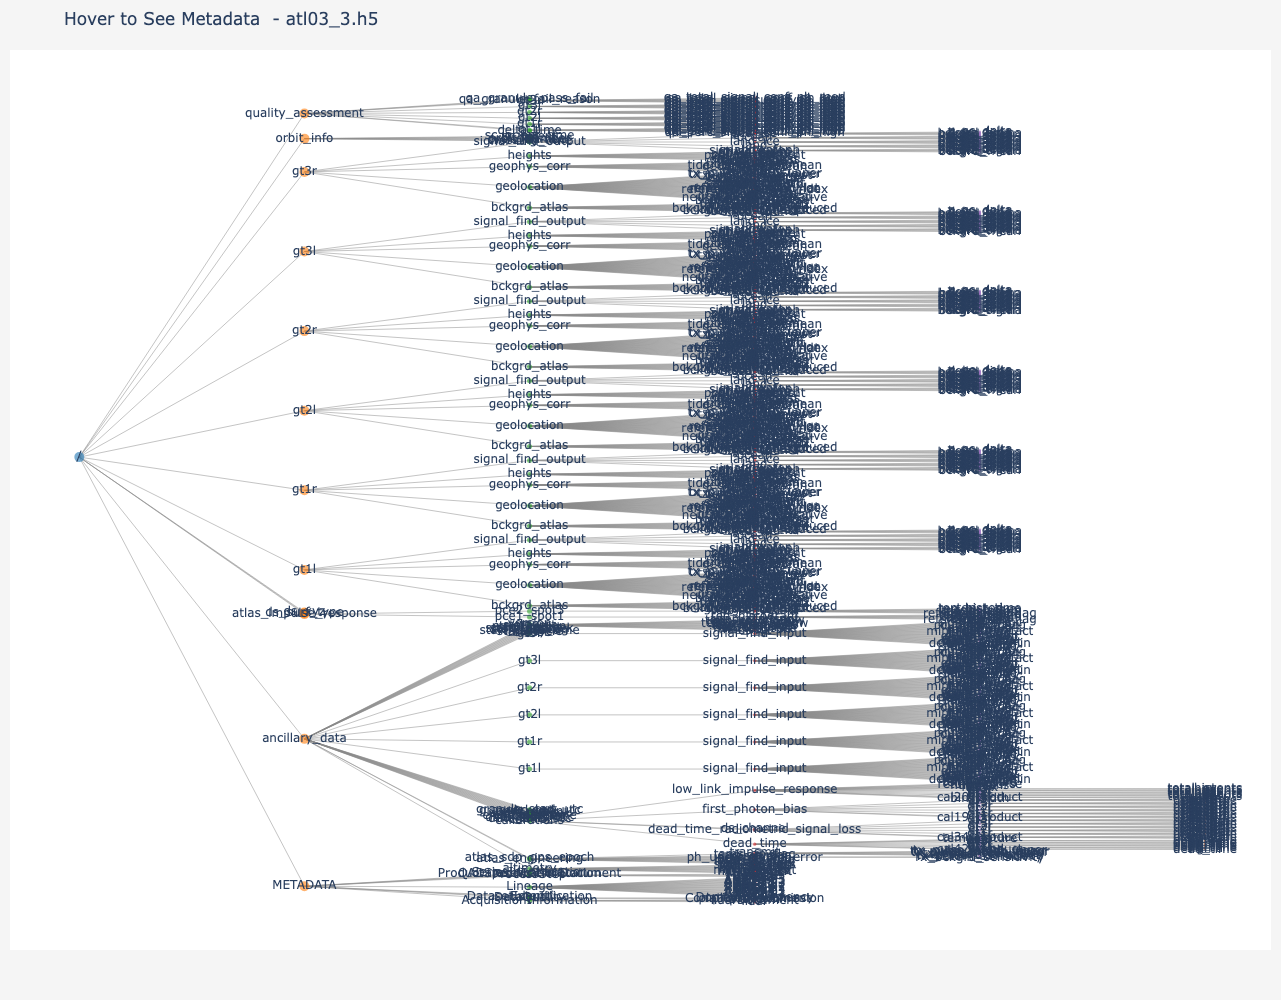

In [96]:
class H5XRay:
    def __init__(self, filepath, max_depth=None, show_text=True, figure_size=(1000, 1000)):
        """
        Constructor for the H5XRay class.

        Args:
            filepath (str): Path to the HDF5 file to visualize.
            max_depth (int, optional): Maximum depth to visualize in the tree. If None, visualize entire tree.
            show_text (bool, optional): Whether to display text labels on nodes in the graph.
            figure_size (tuple, optional): Dimensions for the output visualization (width, height).
        """
        self.filepath = filepath
        self.G = None
        self.show_text = show_text
        self.figure_size = figure_size
        self.generate_igraph_tree(max_depth=max_depth)

    def scan_hdf5(self, current_group, depth=0):
        """
        Recursively scan an HDF5 group to derive its structure.

        Args:
            current_group (h5py.Group): Current HDF5 group to scan.
            depth (int): Current depth in the hierarchy.

        Returns:
            list: List of tuples where each tuple represents an item (depth, name, type) in the HDF5 structure.
        """
        items = []

        for key, item in current_group.items():
            attrs = {k: v for k, v in item.attrs.items()}  # Extract attributes

            if isinstance(item, h5py.Dataset):
                size = item.size * item.dtype.itemsize
                dtype = str(item.dtype)
                shape = str(item.shape)
                items.append((depth, key, 'dataset', size, dtype, shape, attrs))
            elif isinstance(item, h5py.Group):
                items.append((depth, key, 'group', 'na', 'na', 'na', attrs))
                items.extend(self.scan_hdf5(item, depth=depth + 1))

        return items

    def hdf5_to_igraph_tree(self, group, parent_name='/', depth=0, max_depth=None):
        """
        Converts an HDF5 group into an igraph tree representation. Used for visualization.

        Args:
            group (h5py.Group): The current HDF5 group.
            parent_name (str): The hierarchical name of the current group.
            depth (int): Current depth in the hierarchy.
            max_depth (int, optional): Maximum depth for visualization.
        """
        if self.G is None:
            self.G = ig.Graph(directed=True)
            self.G.add_vertex(name=parent_name, label=parent_name.split('/')[-1] or '/')

        if max_depth is not None and depth > max_depth:
            return

        for key, item in group.items():
            vertex_name = f"{parent_name}/{key}" if parent_name != '/' else f"{parent_name}{key}"

            attrs = {k: v for k, v in item.attrs.items()}  # Extract attributes
            dtype, shape, size = 'na', 'na', 'na'
            if isinstance(item, h5py.Dataset):
                size = item.size * item.dtype.itemsize
                dtype = str(item.dtype)
                shape = str(item.shape)

            self.G.add_vertex(name=vertex_name, label=key, depth=depth, size=str(size), dtype=dtype, shape=shape, attrs=attrs)
            self.G.add_edge(parent_name, vertex_name)

            if isinstance(item, h5py.Group):
                self.hdf5_to_igraph_tree(item, vertex_name, depth + 1, max_depth)


    def generate_igraph_tree(self, max_depth=None):
        """
        Generates the igraph tree representation of the HDF5 file.

        Args:
            max_depth (int, optional): Maximum depth for visualization.
        """
        if self.G is None:
            with h5py.File(self.filepath, 'r') as f:
                self.G = None
                self.hdf5_to_igraph_tree(f['/'], max_depth=max_depth)

    def create_plotly_figure(self):
        """
        Create the Plotly figure for visualization.

        Returns:
            go.Figure: The Plotly figure object.
        """
        if self.G is None:
            raise ValueError("No graph data available. Please run generate_igraph_tree first.")

        layout = self.G.layout_reingold_tilford(root=[0])

        x = [coord[0] for coord in layout]
        y = [coord[1] for coord in layout]

        unique_depths = set(v['depth'] + 1 if v['depth'] is not None else 0 for v in self.G.vs)
        max_depth = max(unique_depths)
        categorical_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        color_palette = [categorical_colors[i % len(categorical_colors)] for i in range(max_depth + 1)]

        edge_trace = go.Scatter(
            x=[], y=[], line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

        for edge in self.G.es:
            source, target = edge.tuple
            x0, y0 = layout[source]
            x1, y1 = layout[target]
            edge_trace['y'] += tuple([x0, x1, None])
            edge_trace['x'] += tuple([y0, y1, None])

        node_sizes = [10 / (v['depth'] + 1 if v['depth'] is not None else 1) for v in self.G.vs]

        hover_texts = []
        for v in self.G.vs:
            base_text = v['label']
            additional_info = []

            # Add size if dataset
            if v['size'] != 'na':
                additional_info.append(f"Size: {v['size']} bytes")

            # Add dtype and shape if dataset
            if v['dtype'] != 'na' and v['shape'] != 'na':
                additional_info.append(f"Type: {v['dtype']}")
                additional_info.append(f"Shape: {v['shape']}")

            # Add attributes (metadata) in a structured manner
            if v['attrs']:
                attr_texts = []
                for k, attr_value in v['attrs'].items():
                    # Check if the value is a byte string and decode if necessary
                    formatted_value = attr_value.decode() if isinstance(attr_value, bytes) else str(attr_value)
                    # Wrap long attribute values
                    wrapped_value = self.wrap_text(formatted_value)
                    attr_text = f"{k}: {wrapped_value}"
                    attr_texts.append(attr_text)

                additional_info.append("Attributes:")
                additional_info.extend(attr_texts)

            full_text = base_text + ("<br>" + "<br>".join(additional_info) if additional_info else "")
            hover_texts.append(full_text)

        node_trace = go.Scatter(
            x=y, y=x,
            mode='markers+text' if self.show_text else 'markers',
            text=[v['label'] for v in self.G.vs] if self.show_text else None,
            hovertext=hover_texts,
            hoverinfo='text',
            marker=dict(
                showscale=False,
                color=[color_palette[v['depth'] + 1 if v['depth'] is not None else 0] for v in self.G.vs],
                size=node_sizes,
                opacity=0.6,
                line_width=0,
            ))

        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(title=f'Hover to See Metadata  - {os.path.basename(self.filepath)}',
                                         showlegend=False, hovermode='closest',
                                         width=self.figure_size[0], height=self.figure_size[1],
                                         margin=dict(b=50, l=10, r=10, t=50),
                                         xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                         yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                         plot_bgcolor='white', paper_bgcolor='whitesmoke'))

        return fig



    def visualize_tree(self, export_path=None):
        """
        Visualizes the tree structure of the HDF5 file using Plotly.

        Args:
            export_path (str, optional): The full path to the output image file, including filename and extension.
                                         If provided, the plot will be exported as an image.
        Raises:
            ValueError: If the graph data isn't available.
        """
        fig = self.create_plotly_figure()  # Create the Plotly figure

        if export_path:
            self.export_figure_as_image(export_path)  # Export the figure as an image

        fig.show()

    def export_figure_as_image(self, full_path, format="png", watermark_text='@jonm3d'):
        """
        Export the Plotly figure as a static image with an optional watermark.

        Args:
            full_path (str): The full path to the output image file, including filename and extension.
            format (str, optional): The format of the output image (e.g., "png", "jpeg", "pdf").
            watermark_text (str, optional): Text to use as a watermark (e.g., "Watermark Text").
        """
        if self.G is None:
            raise ValueError("No graph data available. Please run generate_igraph_tree first.")

        # Create directories as needed
        os.makedirs(os.path.dirname(full_path), exist_ok=True)

        fig = self.create_plotly_figure()  # Create the Plotly figure

        # Save the figure as an image
        fig.write_image(full_path, format=format)

        # Add a watermark if watermark_text is provided
        if watermark_text:
            img = Image.open(full_path)
            draw = ImageDraw.Draw(img)

            # Customize the font size
            font_size = 16  # Adjust the font size as needed

            # Calculate text size and image size using textbbox
            text_bbox = draw.textbbox((0, 0), watermark_text)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            img_width, img_height = img.size

            # Adjust the margin as needed
            margin = 10

            # Calculate the position for the watermark (top right corner)
            position = (img_width - text_width - margin, margin)

            # Set the fill color to solid black
            fill_color = "black"

            # Add the watermark with the modified font size and fill color
            draw.text(position, watermark_text, fill=fill_color)

            # Save the image with the watermark
            img.save(full_path)
            
    def wrap_text(self, text, max_len=50, indent="    "):  # using 4 spaces as indentation by default
        """
        Wrap the given text into lines of no more than max_len characters with indentation for wrapped lines.
        
        Args:
            text (str): The input text.
            max_len (int, optional): Maximum number of characters for each line. Default is 50.
            indent (str, optional): Characters to use for line indentation. Default is 4 spaces.
        
        Returns:
            str: The wrapped text with indentation.
        """
        lines = textwrap.wrap(text, max_len)
        # Only indent from the second line onwards
        indented_lines = [lines[0]] + [indent + line for line in lines[1:]]
        return "<br>".join(indented_lines)

# Example usage:
# Create an instance of the H5XRay class
h5_xray = H5XRay(filepath=input_file, 
                 show_text=True, # annotates each note with the dataset name
                )

# Visualize the tree structure and export as an image
h5_xray.visualize_tree(export_path=input_file_base + '_tree_labels.png')
# h5_xray.visualize_tree()


# Byte-Level Dataset Visualization

In [109]:

def extract_dataset_info(hdf5_file, path='/', request_size_bytes=1024 * 1024):
    """
    Recursively extract information about groups and datasets in an HDF5 file.

    Args:
        hdf5_file (h5py.File): The HDF5 file object.
        path (str): The current path in the HDF5 structure. Defaults to root ('/').
        request_size_bytes (int): The size of each request in bytes.

    Returns:
        list: A list of dictionaries, where each dictionary has details about a group or dataset,
              including the number of requests required to read the dataset.
    """
    results = []
    # Navigate the current group's items.
    for name, item in hdf5_file[path].items():
        # Construct the full path for the current item.
        current_path = f"{path}/{name}" if path != '/' else f"/{name}"
        
        if isinstance(item, h5py.Group):
            # Recursively explore the contents of the group.
            results.extend(extract_dataset_info(hdf5_file, current_path, request_size_bytes))
        elif isinstance(item, h5py.Dataset):
            # If it's a dataset, extract dataset details.
            depth = current_path.count('/') - 1  # Depth is based on the number of slashes in the path.

            # Calculate the number of requests needed to read the dataset
            dataset_size_bytes = item.size * item.dtype.itemsize
            requests_needed = (dataset_size_bytes + request_size_bytes - 1) // request_size_bytes

            dataset_info = {
                'top': current_path.split('/')[1],  # Top level group for visualization
                'name': current_path.split('/')[-1],
                'path': current_path,
                'type': 'Dataset',
                'depth': depth,
                'chunking': item.chunks,
                'bytes': item.id.get_storage_size(),
                'start_byte': item.id.get_offset(),
                'attributes': dict(item.attrs),
                'requests_needed': requests_needed,  # Number of requests required to read the dataset
            }
            results.append(dataset_info)
    return results

# Using the function to construct the DataFrame
with h5py.File(input_file, "r") as hdf5_file:
    file_info = extract_dataset_info(hdf5_file)
    df = pd.DataFrame(file_info)

# Display the DataFrame
df.sample(10).head()


,top,name,path,type,depth,chunking,bytes,start_byte,attributes,requests_needed
150,ancillary_data,n_delta_z2,/ancillary_data/gt1l/signal_find_input/n_delta_z2,Dataset,3,None,20,None,"{'contentType': b'auxiliaryInformation', 'desc...",1
831,gt3l,t_pc_delta,/gt3l/signal_find_output/inlandwater/t_pc_delta,Dataset,3,"(10000,)",5644,None,{'DIMENSION_LIST': [[<HDF5 object reference>]]...,1
365,gt1l,bckgrd_hist_top,/gt1l/bckgrd_atlas/bckgrd_hist_top,Dataset,2,"(10000,)",45241,None,{'DIMENSION_LIST': [[<HDF5 object reference>]]...,1
649,gt2l,delta_time,/gt2l/signal_find_output/ocean/delta_time,Dataset,3,"(10000,)",113335,None,"{'CLASS': b'DIMENSION_SCALE', 'NAME': b'delta_...",1
340,ancillary_data,tep_prim_window,/ancillary_data/tep/tep_prim_window,Dataset,2,None,8,None,"{'contentType': b'auxiliaryInformation', 'desc...",1


In [111]:
# how to address chunking? some of the datasets are 2D
# df.chunking.values

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_dataframe(df, annotate=True, font_size=10, byte_threshold=0, title="", 
                   orientation='horizontal', figsize=(7, 9), output_file=None, max_requests=20):
    
    # df = df.sort_values(by='bytes', ascending=True).copy()

    # Normalize the 'requests_needed' values between 0 and 1 with an upper bound of max_requests
    df['norm_requests'] = df['requests_needed'].apply(lambda x: min(x, max_requests) / max_requests)

    # Map the normalized values to a colormap
    df['color'] = df['norm_requests'].apply(lambda x: plt.cm.Reds(x))

    # Plotting
    plt.figure(figsize=figsize)
    
    # Variable to keep track of height/width for stacking
    stacked_value = 0 

    edge_color = 'black' if annotate else None
    linewidth = 0.05 if annotate else 0

    for index, row in df.iterrows():
        if orientation == 'horizontal':
            plt.bar('Combined', row['bytes'], bottom=stacked_value, color=row['color'], edgecolor=edge_color, linewidth=linewidth)
            if annotate and row['bytes'] > byte_threshold:
                chunk_center = stacked_value + row['bytes'] / 2
                plt.text('Combined', chunk_center, row['name'], ha='center', va='center', color='black', fontsize=font_size)
        else:
            plt.barh('Combined', row['bytes'], left=stacked_value, color=row['color'], edgecolor=edge_color, linewidth=linewidth)
            if annotate and row['bytes'] > byte_threshold:
                chunk_center = stacked_value + row['bytes'] / 2
                plt.text(chunk_center, 'Combined', row['name'], ha='center', va='center', color='black', fontsize=font_size, rotation=90)
        
        stacked_value += row['bytes']

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=max_requests))
    sm.set_array([])
    cbar = plt.colorbar(sm)  # Specify the axis for the colorbar
    cbar.set_label('Requests Needed', rotation=270, labelpad=15)
                
    # Remaining parts of plotting function adjusted for orientation and without tick labels
    if orientation == 'horizontal':
        plt.ylabel('Bytes (unordered)')
        plt.xticks([])  # Remove tick labels
        plt.yticks([])
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
    else:
        plt.xlabel('Bytes (unordered)')
        plt.xticks([])  # Remove tick labels
        plt.yticks([])
        plt.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.title(f"H5XRAY - {title} - Total Size: {stacked_value / (1024**2):.2f} MB")
    plt.annotate('@jonm3d - In Progress', (1,1), xytext=(-15, 15), va='top', 
                 ha='right', xycoords='axes fraction', textcoords='offset points', fontsize=12, alpha=0.7)
    plt.tight_layout()

    # Save the plot to a PNG file if an output file path is provided
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)  # Adjust DPI as needed
    else:
        plt.show()


/tmp/ipykernel_2125/1847706209.py:42: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



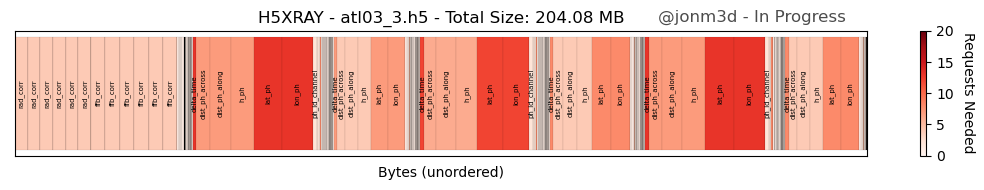

In [161]:
plot_dataframe(df, 
               annotate=True, font_size=5, 
               byte_threshold=1024**2/2, # minimum bytes required to get annotated
               title=input_file.split('/')[-1], 
               orientation='vertical', figsize=(11,2),
               output_file=f"{input_file_base}_bytes.png")